<a href="https://colab.research.google.com/github/ejshumaker/SUAutoencoder/blob/master/HSU_autoencoder_cuprite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary
from tqdm import tqdm

from scipy import io

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
if os.path.exists('./data'):
  ! rm -r ./data
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/train/sub')
os.mkdir('./data/test')
os.mkdir('./data/test/sub')
train_path = './data/train/sub'
test_path = './data/test/sub'

In [0]:
data_dict = io.loadmat("/content/gdrive/My Drive/Research/SpectralUnmixing/CupriteS1_R188.mat")
gt_dict = io.loadmat("/content/gdrive/My Drive/Research/SpectralUnmixing/groundTruth_Cuprite_nEnd12.mat")

In [5]:
print(gt_dict['M'][:,0])
print(gt_dict['cood'][0])

[0.55742017 0.57629787 0.5937831  0.61208907 0.63083819 0.6470653
 0.65849169 0.66716597 0.67841419 0.68965327 0.70284842 0.7166223
 0.7326101  0.74552892 0.75942867 0.77239759 0.78207446 0.78652031
 0.79471264 0.80235932 0.80622183 0.81082253 0.81456461 0.82021499
 0.82162232 0.82758799 0.83242546 0.83691312 0.8398638  0.8316466
 0.8363707  0.83964622 0.84298113 0.84717387 0.85239708 0.8575575
 0.86070349 0.86301008 0.86549311 0.86944796 0.87170593 0.87284815
 0.87603421 0.877416   0.8795674  0.88092771 0.88147779 0.88255227
 0.88128306 0.88343003 0.88433875 0.8823254  0.88108355 0.87740239
 0.88119636 0.88056295 0.88046093 0.8783341  0.8793033  0.87734814
 0.87659611 0.87850059 0.87894281 0.88007618 0.878423   0.8783454
 0.8786372  0.88070941 0.88356713 0.8843906  0.88468872 0.8858385
 0.88725559 0.88684734 0.889313   0.88968963 0.8893848  0.88974322
 0.89154557 0.8917604  0.89086798 0.89209216 0.89004245 0.8904734
 0.8909154  0.89295167 0.89125552 0.89181591 0.89183155 0.89168692
 0

## Direct Dataloader

In [0]:
Y = data_dict['Y']
dataset = []
for i in range(Y.shape[0]):
  d = Y[:,i]
  d = d / np.amax(d)
  t = torch.Tensor(d)
  dataset.append(t)
dataloader = DataLoader(dataset)

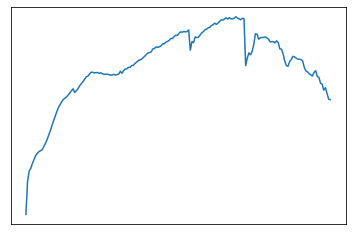

In [7]:
example = dataloader.__iter__().__next__()[0]
plt.plot(example)
plt.xticks([])
plt.yticks([])
plt.show()

torch.Size([1, 188])
torch.Size([188])
;;;;;;;
torch.Size([1, 188])
torch.Size([188])
;;;;;;;


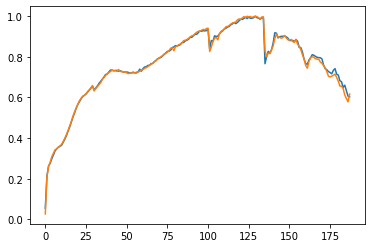

In [0]:
for i, x in enumerate(dataloader):
  if i < 2:
    print(x.shape)
    print(x[0].shape)
    print(';;;;;;;')
    plt.plot(x[0])

## Plot and save data

In [0]:
img_data = True
Y = data_dict['Y']
if img_data:
  for i in range(Y.shape[0]):
    y = Y[:,i]
    y = y.reshape((188,1))
    plt.plot(y)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    img_path = train_path + '/%d.jpg' % (i + 1)
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0.0)
    plt.clf()

<Figure size 432x288 with 0 Axes>

### Crop Images

In [0]:
# Only run once
path = './data/train/sub/'
for filename in os.listdir(path):
  img_path = os.path.join(path, filename)
  img = cv2.imread(img_path)
  row, col, channel = img.shape
  img = img[5:,15:(col-14),:]
  # print(img.shape)
  cv2.imwrite(img_path, img)

## Dataloader

In [0]:
def load_data(path, subfolder, transform, batch_size=1, shuffle=True):
    """
    Data loader.

    Inputs:
    - path: path of the data.
    - subfolder: subfolder of the data.
    - transform: data transformation.
    - batch_size: the size of the batch
    - shuffle: if true, shuffle the data

    Outputs:
    - torch Dataloader
    """
    # direc = path + '/' + subfolder
    direc = path + '/'
    dset = datasets.ImageFolder(direc, transform=transform)
    dataloader = DataLoader(dset,batch_size=batch_size,shuffle=shuffle)
    return dataloader

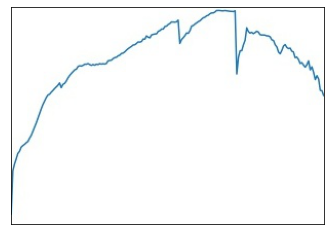

In [0]:
# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
])
train_loader = load_data('./data', 'train', transform, batch_size =1, shuffle=True)

# plot sample image
example = train_loader.__iter__().__next__()[0][0].numpy().transpose((1, 2, 0))
plt.imshow(example)
plt.xticks([])
plt.yticks([])
plt.show()

## Autoencoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Encoder, self).__init__()

        # TODO: change architecture
        B = 188 # spectral bands
        R = 12  # endmembers
        self.encoder = nn.Sequential(
            # nn.Linear(in_channels, B),
            nn.Conv1d(in_channels,B,kernel_size=1,stride=2,padding=0),
            nn.ReLU(),
            nn.Conv1d(B,9*R,kernel_size=1,stride=2,padding=0),
            nn.ReLU(),
            nn.Conv1d(9*R,6*R,kernel_size=1,stride=2,padding=0),
            nn.ReLU(),
            nn.Conv1d(6*R,3*R,kernel_size=1,stride=2,padding=0),
            nn.ReLU(),
            nn.Conv1d(3*R,R,kernel_size=1,stride=2,padding=0),
            nn.ReLU(),
            nn.BatchNorm1d(R),
            nn.Softmax(dim=1)
            # soft threshold?
        )


    def forward(self, x):
        '''
        Given a vector x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            h: torch.tensor
        '''
        x = x.reshape((188, 1, -1))
        h = self.encoder(x)
        print("h:",h.shape)

        return h

In [108]:
encoder = Encoder().to(device)
summary(encoder, [(188,1,1)])

h: torch.Size([188, 12, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 188, 1]             376
              ReLU-2               [-1, 188, 1]               0
            Conv1d-3               [-1, 108, 1]          20,412
              ReLU-4               [-1, 108, 1]               0
            Conv1d-5                [-1, 72, 1]           7,848
              ReLU-6                [-1, 72, 1]               0
            Conv1d-7                [-1, 36, 1]           2,628
              ReLU-8                [-1, 36, 1]               0
            Conv1d-9                [-1, 12, 1]             444
             ReLU-10                [-1, 12, 1]               0
      BatchNorm1d-11                [-1, 12, 1]              24
          Softmax-12                [-1, 12, 1]               0
Total params: 31,732
Trainable params: 31,732
Non-trainable params: 0
-----

In [0]:
class Decoder(nn.Module):
    def __init__(self, out_channels=3, feat_dim=64):
        super(Decoder, self).__init__()

        B = 188 # spectral bands
        R = 12  # endmembers

        self.decoder = nn.Sequential(
            # nn.Linear(R, B, bias=False)
            # nn.ConvTranspose1d(R,B,kernel_size=1,stride=1,padding=1),
          nn.ConvTranspose1d(B,R,kernel_size=1,stride=1,padding=0),
          nn.ReLU(),
        )

    def forward(self, h):
        '''
        Given encoded vector h, return decoded vector x_hat

        Args:
            h: torch.tensor

        Return: 
            x_hat: torch.tensor
        '''
        h = h.reshape((12, 188, -1))
        print('input:', h.shape)
        x_hat = self.decoder(h)
        print('x_hat:', x_hat.shape)
        return x_hat

In [119]:
decoder = Decoder().to(device)
summary(decoder, [(188,12)])

input: torch.Size([12, 188, 2])
x_hat: torch.Size([12, 12, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose1d-1                [-1, 12, 2]           2,268
              ReLU-2                [-1, 12, 2]               0
Total params: 2,268
Trainable params: 2,268
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [0]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(in_channels=1)
        self.decoder = Decoder()

    def forward(self, x):
        '''
        Compress and reconstruct the input image with encoder and decoder.

        Args:
            x: torch.tensor

        Return: 
            x_: torch.tensor
        '''

        h = self.encoder(x)
        x_ = self.decoder(h)

        return x_

In [0]:
ae = Autoencoder().to(device)
# summary(ae, (3, 64, 64))

In [0]:
def visualize_recon(model, dataloader):
    '''
    Helper function for visualizing reconstruction performance.

    Randomly sample 8 images and plot the original/reconstructed images. 
    '''
    model.eval()
    img = next(iter(dataloader))[0][:8].to(device)
    out = model(img)

    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    inp = torchvision.utils.make_grid(torch.cat((img, out), dim=2), nrow=8)
    imshow(inp.detach().cpu(), ax=ax)
    model.train()
    plt.show()

In [0]:
def train_ae(model, dataloader, epochs=200):
    '''
    Train autoencoder model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader. The unlabeled partition of the STL dataset.
    '''

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    loss_traj = []

    for epoch in tqdm(range(epochs)):

        loss_epoch = 0
        for x in dataloader:
            # print(x.shape)

            inp = x[0].to(device)
            # inp = inp.view(1, -1)
            out = model(inp)
            loss = criterion(out, inp)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}'.format(epoch, loss_epoch))
            visualize_recon(model, dataloader)

    return model, loss_traj

In [120]:
# Train the autoencoder for 100 epochs
ae = Autoencoder().to(device)
ae, ae_loss_traj = train_ae(ae, dataloader, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([188])) that is different to the input size (torch.Size([12, 12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])

  0%|          | 0/100 [00:04<?, ?it/s]

h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
h: torch.Size([188, 12, 1])
input: torch.Size([12, 188, 1])
x_hat: torch.Size([12, 12, 1])
Epoch 0, loss 36.021


RuntimeError: ignored

In [0]:
i = 0
for x in dataloader:
  i += 
  print(i)
  # x = x.view(x.size(0), -1)
  # print(x.shape)